#### cleanups requeired
- Remove puncations
- Remove html tags

In [101]:
import warnings
warnings.filterwarnings('ignore')

In [102]:
import pandas as pd
import gzip

In [103]:
from gensim import corpora, models
from gensim.models import CoherenceModel
import gensim

import pyLDAvis
from pprint import pprint

In [134]:
import matplotlib.pyplot as plt
%matplotlib inline

In [104]:
#spacy
import spacy
from spacy import displacy

#load basic en model (without embeddings)
nlp = spacy.load('en_core_web_sm')

In [105]:
spacy_stopwords = spacy.lang.en.stop_words.STOP_WORDS

In [106]:
## this is the dataset downloaded from AMZN directly.
mobile_electronics_review = 'amazon_reviews_us_Mobile_Electronics_v1_00.tsv.gz'

# skipping bad lines.
df = pd.read_table(mobile_electronics_review, error_bad_lines=False)

# let's see some data
df.head()

b'Skipping line 35246: expected 15 fields, saw 22\n'
b'Skipping line 87073: expected 15 fields, saw 22\n'


,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
0,US,20422322,R8MEA6IGAHO0B,B00MC4CED8,217304173,BlackVue DR600GW-PMP,Mobile_Electronics,5.0,0.0,0.0,N,Y,Very Happy!,"As advertised. Everything works perfectly, I'm...",2015-08-31
1,US,40835037,R31LOQ8JGLPRLK,B00OQMFG1Q,137313254,GENSSI GSM / GPS Two Way Smart Phone Car Alarm...,Mobile_Electronics,5.0,0.0,1.0,N,Y,five star,it's great,2015-08-31
2,US,51469641,R2Y0MM9YE6OP3P,B00QERR5CY,82850235,iXCC Multi pack Lightning cable,Mobile_Electronics,5.0,0.0,0.0,N,Y,great cables,These work great and fit my life proof case fo...,2015-08-31
3,US,4332923,RRB9C05HDOD4O,B00QUFTPV4,221169481,abcGoodefg® FBI Covert Acoustic Tube Earpiece ...,Mobile_Electronics,4.0,0.0,0.0,N,Y,Work very well but couldn't get used to not he...,Work very well but couldn't get used to not he...,2015-08-31
4,US,44855305,R26I2RI1GFV8QG,B0067XVNTG,563475445,Generic Car Dashboard Video Camera Vehicle Vid...,Mobile_Electronics,2.0,0.0,0.0,N,Y,Cameras has battery issues,"Be careful with these products, I have bought ...",2015-08-31


In [107]:
# sort by product_id to see if there are multiple reviews for a given product, and display few items.
df.sort_values(by=['product_id'], ascending = False)[1:10]

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
627,US,45880701,R1SMDKEE2ZMTPU,B01416742A,642884794,Powerful Wireless Bluetooth Speaker with High ...,Mobile_Electronics,5.0,0.0,1.0,N,N,Beautiful and crisp sound coupled with sleek a...,Very impressive<br /><br />I am very rarely im...,2015-08-21
558,US,42532274,R2S4XKV164VN6I,B01416742A,642884794,Powerful Wireless Bluetooth Speaker with High ...,Mobile_Electronics,1.0,1.0,1.0,N,N,This Bluetooth speaker is awful. The sound qu...,I want to first start out by saying that I rec...,2015-08-22
517,US,16581575,R2XQW11Z3GD2Q8,B013OGQME4,529796292,[Most Powerful Portable Speaker Ever]Omaker 10...,Mobile_Electronics,5.0,3.0,4.0,N,N,I was skeptical at first since this speaker is...,I was skeptical at first since this speaker is...,2015-08-23
245,US,32038204,R1N5H6E5242VW,B013OGQME4,529796292,[Most Powerful Portable Speaker Ever]Omaker 10...,Mobile_Electronics,4.0,6.0,7.0,N,N,"Points of Observations (Audio, Fit & Build, Bl...",[[VIDEOID:fa85e618a003596a96e0cd0a6b306a41]]Pa...,2015-08-27
274,US,188059,R2HLT9RAXJYINC,B013AJYRCY,157957729,"Portable Bluetooth Speaker,sound Cube Portable...",Mobile_Electronics,4.0,2.0,2.0,N,N,Sounds pretty good for its size,Sounds pretty good for its size. It comes with...,2015-08-27
637,US,32588808,R1R4WMZZTUVW3Q,B013AJYRCY,157957729,"Portable Bluetooth Speaker,sound Cube Portable...",Mobile_Electronics,5.0,0.0,0.0,N,N,Little speaker with big functions.,Small speaker with a big sound. The speaker i...,2015-08-21
400,US,21279067,R15HQ2NJS614NB,B013AJYRCY,157957729,"Portable Bluetooth Speaker,sound Cube Portable...",Mobile_Electronics,3.0,0.0,0.0,N,N,"Sounds good, no instructions.",I have used several of these mini speakers.<br...,2015-08-25
748,US,1067307,R14S84LPBYS3RY,B0131NRA9Q,364875917,Pax 2 Hard Plastic Case (Black),Mobile_Electronics,5.0,1.0,1.0,N,N,Awesome Case,Recently purchased the same product on ebay. C...,2015-08-19
602,US,9808333,R3VTF0Y2U0W38D,B0131NRA9Q,364875917,Pax 2 Hard Plastic Case (Black),Mobile_Electronics,5.0,0.0,0.0,N,N,Great case for Pax 2,"After lots of searching, I bought one of these...",2015-08-21


In [108]:
sample_product = 'B010P73G76'

In [109]:
#don't want puncuations, spaces as tokens
tokenize_blacklist = ['PUNCT', 'SPACE']

In [110]:
%%time

#let's try for a single product first
df_sample = df[df.product_id == sample_product]
num_reviews = df_sample.shape[0]

doc_set = df_sample.review_body #[df_sample.review_body[i] for i in range(num_reviews)]

texts = []

for doc in doc_set:
    # print(doc)
    
    # putting our three steps together
    
    #1. Tokenize
    doc_sp = nlp(doc)
    tokens = [token.text.lower() for token in doc_sp if token.pos_ not in tokenize_blacklist]
    #tokens = [token.text.lower() for token in doc_sp]
    if(len(tokens) < 3):
        continue
    #2. remove stop words
    stopped_tokens = [token for token in tokens if not token in spacy_stopwords]
    
    #3. lemmetize
    lemmed_tokens = []
    for stopped_token in stopped_tokens:
        lemmed_nlp = nlp(stopped_token)
        lemmed_token = lemmed_nlp[0].lemma_
        lemmed_tokens.append(lemmed_token)
    
    
    # add tokens to list, let's start with stopped_tokens, lemmitization is messing up.
    # for loop so that we don't get list of lists
    for stopped_token in stopped_tokens:
        texts.append(stopped_tokens)

Wall time: 4.09 s


## Create bigram and trigram models

In [111]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
#def remove_stopwords(texts):
#    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [112]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(texts, min_count=5, threshold=10) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[texts], threshold=30)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[texts[0]]])

['flimsy', "n't", 'work', 'new', 'technology_touching', 'like', 'ipad_remember', 'button', 'example_video', 'music']


In [113]:
# Form Bigrams
data_words_bigrams = make_bigrams(texts)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
#nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
#data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_words_bigrams[:1])

[['flimsy', "n't", 'work', 'new', 'technology_touching', 'like', 'ipad_remember', 'button', 'example_video', 'music']]


### Create the Dictionary and Corpus needed for Topic Modeling

In [124]:
candidate_text = texts # unigrams :Perplexity:  -4.377417073025684 Coherence Score:  0.7472006215139164
#candidate_text = data_words_bigrams ## Perplexity:  -4.377417073025684  Coherence Score:  0.7472006215139164

# Create Dictionary
id2word = corpora.Dictionary(candidate_text)

# Create Corpus
texts = candidate_text

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1)]]


In [125]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('button', 1),
  ('example_video', 1),
  ('flimsy', 1),
  ('ipad_remember', 1),
  ('like', 1),
  ('music', 1),
  ("n't", 1),
  ('new', 1),
  ('technology_touching', 1),
  ('work', 1)]]

In [126]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [127]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.959*"like" + 0.000*"music" + 0.000*"card" + 0.000*"sd" + 0.000*"button" + '
  '0.000*"sure" + 0.000*"create" + 0.000*"days" + 0.000*"format" + '
  '0.000*"n\'t"'),
 (1,
  '0.059*"volume" + 0.039*"buttons" + 0.039*"figure" + 0.039*"pushes" + '
  '0.039*"audio" + 0.020*"easy" + 0.020*"apple" + 0.020*"loses" + '
  '0.020*"memorize" + 0.020*"messing"'),
 (2,
  '0.083*"volume" + 0.083*"easy" + 0.083*"menu_ver" + 0.083*"tried" + '
  '0.083*"so.<br_/>bottom" + 0.083*"navigate" + 0.083*"lower" + '
  '0.083*"5_stars" + 0.083*"day.<br_/>radio" + 0.083*"task_graphics"'),
 (3,
  '0.526*"n\'t" + 0.224*"long" + 0.178*"like" + 0.000*"player" + 0.000*"mp3" + '
  '0.000*"button" + 0.000*"better" + 0.000*"\'ll" + 0.000*"think" + '
  '0.000*"plays_flac"'),
 (4,
  '0.659*"great" + 0.165*"figure" + 0.165*"playing" + 0.000*"volume" + '
  '0.000*"apple" + 0.000*"audio" + 0.000*"pushes" + 0.000*"buttons" + '
  '0.000*"easy" + 0.000*"on.<br"'),
 (5,
  '0.004*"mp3" + 0.004*"player" + 0.004*"basic" + 0

In [128]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=candidate_text, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -4.377417073025684

Coherence Score:  0.7472006215139164


### How to find the optimal number of topics for LDA?

In [132]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        #model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=id2word,  num_topics=num_topics, random_state=100, update_every=1, chunksize=100, passes=10,  alpha='auto',  per_word_topics=True)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [133]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=candidate_text, start=2, limit=40, step=6)

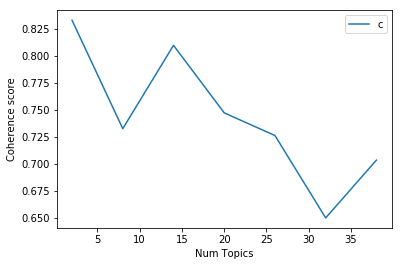

In [135]:
# Show graph
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

### Looks like topic of length 2 has best coherence score. Let's use that score